<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Tutorial: The Structure of the Clifford Group

### Contributors

Shelly Garion$^1$ and Gadi Aleksandrowicz$^1$

1. IBM Research Haifa, Haifa University Campus, Mount Carmel Haifa, Israel

### Qiskit Package Versions

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.10.3',
 'qiskit-terra': '0.8.1',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.1',
 'qiskit-ibmq-provider': '0.2.2',
 'qiskit-aqua': '0.5.1'}

## Introduction 

The goal of this notebook is to describe the structure of the **Clifford group**. This group consists of the quantum operators that can be efficiently simulated (in polynomial time) using a classical computer, via a **Clifford simulator** (see [1]). 
In addition, the Clifford group is used for **Randomized Benchmarking**.

## Definiton

The **Pauli group** $P_n$ on $n$-qubits is generated by the $n$-fold tensor products of the **Pauli matrices** $\{I,X,Y,Z\}$:

$$I=\left(\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right),X=\left(\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right),Y=\left(\begin{array}{cc}
0 & -i\\
i & 0
\end{array}\right),Z=\left(\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right)$$

We denote $A \equiv B$ if $A = \lambda B$ for some $\lambda \in \mathbb{C}$, and define $U(1) = \{\lambda I_n: \lambda \in \mathbb{C} \} \cong \mathbb{C}$. Under this equivalence relation (i.e., neglecting the global phase), we have the following relations betweeen the Pauli matrices:

$$XY\equiv YX \equiv Z$$
$$YZ\equiv ZY \equiv X$$
$$ZX\equiv XZ \equiv Y$$
$$X^{2}=Y^{2}=Z^{2}=I$$

so the group $\{I,X,Y,Z\}$ is isomorphic to the Klein four-group $\mathbb{F}_2^2$ and in general we have the group isomorphism $P_n/U(1) \cong \mathbb{F}_2^{2n}$.

The **Clifford group** $C_n$ on $n$-qubits is defined as the normalizer of the Pauli group $P_n$, when neglecting the global phase $U(1) \cong \mathbb{C}$ (see [2]).

It turns out that $C_n/P_n \cong Sp(2n)$, where $Sp(2n)$ denotes the group of $2n \times 2n$ **symplectic matrices** over the field $\mathbb{F}_2$, which is *simple* for $n>2$ (see [3]). We recall that the symplectic group $Sp(2n)$ is the group of $2n \times 2n$ matrices $S$ with entries in the field $\mathbb{F}_2$ such that $S \Lambda (n) S^{T} = \Lambda (n)$ where $\Lambda (n) = \oplus_{i=1}^n$  $\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}$.

We explicitly describe below the structure and elements in 1-qubit Clifford group $C_1$ and the 2-qubit Cliffod group $C_2$.

### References

[1] Scott Aaaronson and Daniel Gottesman, Improved Simulation of Stabilizer Circuits, https://arxiv.org/abs/quant-ph/0406196

[2] Maris Ozlos, Clifford group, 2008,
http://home.lu.lv/~sd20008/papers/essays/Clifford%20group%20[paper].pdf 

[3] Robert Koenig and John Smolin, How to efficiently select an arbitrary Clifford group element, https://arxiv.org/abs/1406.2170

[4] A. D. C'orcoles, Jay M. Gambetta, Jerry M. Chow, John A. Smolin, Matthew Ware, J. D. Strand, B. L. T. Plourde, and M. Steffen, Supplementary material for ''Process verification of two-qubit quantum gates by randomized benchmarking'', https://arxiv.org/pdf/1210.7011.pdf 

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import *
import itertools
from IPython.display import display
init_printing() #allows nice math displays

### Quantum matrix class

We use the following class to explicitly present a quantum matrix in the Clifford group $C_1$ up to a global phase (coefficient).

In [3]:
class QuantumMatrix():
    def __init__(self, m, coeff = 1):
        self.matrix = sympy.Matrix(m)
        self.coefficient = coeff
        self.canonize()
        
    def canonize(self):
        a = next((x for x in self.matrix if x != 0), None)
        if a is not None: #zero vector
            for i,j in itertools.product([0,1], [0,1]):
                self.matrix[i,j] = sympy.simplify(self.matrix[i,j] / a)
        self.coefficient = sympy.simplify(self.coefficient * a) 
            
    def __str__(self):
        coeff_string = ""
        if self.coefficient != 1:
            coeff_string = "{} * ".format(self.coefficient)
        return "{}[[{}, {}], [{}, {}]]".format(coeff_string,self.matrix[0], self.matrix[1], self.matrix[2], self.matrix[3])
    
    def __mul__(self, rhs):
        return QuantumMatrix(self.matrix * rhs.matrix, self.coefficient * rhs.coefficient)
    
    def __add__(self, rhs):
        temp_rhs_matrix = sympy.Matrix([[1,0],[0,1]])
        for i,j in itertools.product([0,1], [0,1]):
                 temp_rhs_matrix[i,j] = sympy.simplify((rhs.matrix[i,j] * self.coefficient) / rhs.coefficient)
        return QuantumMatrix(self.matrix + temp_rhs_matrix, self.coefficient * 1/sympy.sqrt(2))
    
    def __sub__(self, rhs):
        return self + QuantumMatrix(rhs.matrix, rhs.coefficient * -1)
    
    def __eq__(self, rhs):
        return (self.matrix == rhs.matrix and self.coefficient == rhs.coefficient)
    
    def equiv(self, rhs):
        return (self.matrix == rhs.matrix)
    
    def __iter__(self):
        for x in self.matrix:
             yield x

## The Clifford group on 1 qubit

The **Pauli group** $P_1$ is generated by the Pauli matrices $\{I,X,Y,Z\}$. When neglecting the global phase $U(1) \cong \mathbb{C}$ we get that $P_1/U(1) \cong \mathbb{F}_2^2$. 

The **Clifford group** $C_1$ on 1-qubit is defined as the normalizer of the Pauli group $P_1$ (when neglecting the global phase $U(1) \cong \mathbb{C}$).

It turns out that $C_1/P_1 \cong Sp(2) \cong SL(2,2) \cong S_3$, where $Sp(2)$ and $SL(2,2)$ denote the $2 \times 2$ symplectic matrices and the $2 \times 2$ matrices of determinant 1 over the field with 2 elements, respectively, and $S_3$ is the symmetric group on 3 elements. Indeed, one can explicitly verify that 

$$Sp(2) \cong SL(2,2) = \left\{ \begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix} , 
\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix} , \begin{pmatrix} 1 & 1 \\ 0 & 1\end{pmatrix} ,
\begin{pmatrix} 1 & 0 \\ 1 & 1\end{pmatrix} , \begin{pmatrix} 0 & 1 \\ 1 & 1\end{pmatrix} ,
\begin{pmatrix} 1 & 1 \\ 1 & 0\end{pmatrix} \right\} \cong S_3$$

We can think of $C_1$ as rotations of the Bloch sphere that permutes $\pm x, \pm y, \pm z$ directions. There are 6 possibilities where the $x$ axis can go. Once we have fixed the $x$ axis, we can still rotate around it and thus there are 4 possibilities where the $z$ axis can go. Thus $C_1$ corresponds to the group $S_4$ of rotational symmetries of the cube (of order 24).

We will explicitly show these statements below.

### Pauli gates

The Pauli matrices (when neglecting the global phase):
Identity: I=


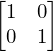

X=


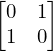

Y=


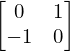

Z=


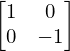

In [4]:
X = QuantumMatrix( [[0,1],  [1,0]])
Y = QuantumMatrix( [[0,-sympy.I], [sympy.I,0]])
Z = QuantumMatrix( [[1,0],  [0,-1]])
I = QuantumMatrix( [[1,0],  [0,1]])

print ("The Pauli matrices (when neglecting the global phase):")
print ("Identity: I=")
display(sympy.Matrix(I.matrix))
print ("X=")
display(sympy.Matrix(X.matrix))
print ("Y=")
display(sympy.Matrix(Y.matrix))
print ("Z=")
display(sympy.Matrix(Z.matrix))

The Pauli gates X,Y,Z are of order 2:
X*X=


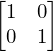

Y*Y=


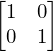

Z*Z=


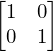

In [5]:
print ("The Pauli gates X,Y,Z are of order 2:")
A=X*X
print ("X*X=")
display(sympy.Matrix(A.matrix))
A=Y*Y
print ("Y*Y=")
display(sympy.Matrix(A.matrix))
A=Z*Z
print ("Z*Z=")
display(sympy.Matrix(A.matrix))

For example, one can verify that X*Y=Y*X=Z:
X*Y = Z =


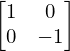

Y*X = Z =


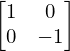

Similarly, X*Z=Z*X=Y, Y*Z=Z*Y=X


In [6]:
print ("For example, one can verify that X*Y=Y*X=Z:")
A=X*Y
B=Y*X
print ("X*Y = Z =")
display(sympy.Matrix(A.matrix))
print ("Y*X = Z =")
display(sympy.Matrix(B.matrix))
print ("Similarly, X*Z=Z*X=Y, Y*Z=Z*Y=X")

In conclusion, we obtain an isomorphism of groups: $P_1/U(1) \cong \mathbb{F}_2^2$.

We now discuss other elements in the Clifford group (when neglecting the global phase).

### Hadamard gate

Hadamard gate: H=


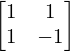

H is of order 2:
H*H =


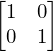

H operates on the Pauli gates by conjugation as a reflection: X<-->Z:
H*X*H = Z =


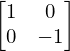

H*Z*H = X =


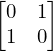

H*Y*H = Y =


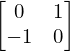

In [7]:
H = QuantumMatrix(  [[1,1],  [1,-1]], 1/sympy.sqrt(2))
print ("Hadamard gate: H=")
display(sympy.Matrix(H.matrix))

print ("H is of order 2:")
A=H*H
print ("H*H =")
display(sympy.Matrix(A.matrix))

print ("H operates on the Pauli gates by conjugation as a reflection: X<-->Z:")
A=H*X*H
print("H*X*H = Z =")
display(sympy.Matrix(A.matrix))
A=H*Z*H
print("H*Z*H = X =")
display(sympy.Matrix(A.matrix))
A=H*Y*H
print("H*Y*H = Y =")
display(sympy.Matrix(A.matrix))

We therefore get the commutator relations:
$$HX=ZH$$
$$HZ=XH$$
$$HY=YH$$

### Phase gate

Phase gate: S=


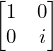

Z=S*S, thus S has order 4, and the inverse of S is S*Z:
S*S = Z =


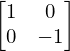

The inverse of S: Sdg = S*Z =


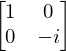

Indeed, S*Sdg =


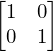

In [8]:
S = QuantumMatrix(  [[1,0],  [0,sympy.I]])
print ("Phase gate: S=")
display(sympy.Matrix(S.matrix))

print ("Z=S*S, thus S has order 4, and the inverse of S is S*Z:")
A=S*S
print ("S*S = Z =")
display(sympy.Matrix(A.matrix))
print ("The inverse of S: Sdg = S*Z =")
Sdg = S*Z
display(sympy.Matrix(Sdg.matrix))
print ("Indeed, S*Sdg =")
A = S*Sdg
display(sympy.Matrix(A.matrix))

S operates on the Pauli gates by conjugation as a reflection: Y<-->Z:
S*X*Sdg = Y =


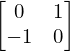

S*Y*Sdg = X =


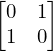

S*Z*Sdg = Z =


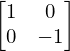

We therefore get the commutator relations:
S*X = Y*S and Sdg*Y = X*Sdg
S*Y = X*S and Sdg*X = Y*Sdg
S*Z = Z*S = Sdg and Sdg*Z = Z*Sdg = S


In [9]:
print ("S operates on the Pauli gates by conjugation as a reflection: Y<-->Z:")
A = S*X*Sdg # =Y
print ("S*X*Sdg = Y =")
display(sympy.Matrix(A.matrix))
print ("S*Y*Sdg = X =")
A = S*Y*Sdg # =X
display(sympy.Matrix(A.matrix))
print ("S*Z*Sdg = Z =")
A = S*Z*Sdg # =Z
display(sympy.Matrix(A.matrix))

print ("We therefore get the commutator relations:")
print ("S*X = Y*S and Sdg*Y = X*Sdg")
print ("S*Y = X*S and Sdg*X = Y*Sdg")
print ("S*Z = Z*S = Sdg and Sdg*Z = Z*Sdg = S")

### The axis swap group

Let: V = H*S*H*S =


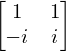

V is of order 3:
V*V*V =


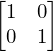

Hence, V = Sdg*H =


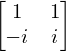

The inverse of V is: W = S*Z*H*S*Z*H = H*S = 


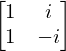

Indeed, W = V*V =


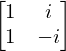

In [10]:
V = H*S*H*S
print ("Let: V = H*S*H*S =")
display(sympy.Matrix(V.matrix))

print ("V is of order 3:")
A=V*V*V
print ("V*V*V =")
display(sympy.Matrix(A.matrix))

print ("Hence, V = Sdg*H =")
A=Sdg*H
display(sympy.Matrix(A.matrix))

print ("The inverse of V is: W = S*Z*H*S*Z*H = H*S = ")
W=H*S
display(sympy.Matrix(W.matrix))

print ("Indeed, W = V*V =")
A=V*V
display(sympy.Matrix(A.matrix))

V operates on the Pauli gates by conjugation as a rotation: Z-->X-->Y-->Z:
W*X*V = Y =


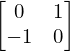

W*Y*V = Z =


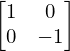

W*Z*V = X = 


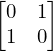

In [11]:
print ("V operates on the Pauli gates by conjugation as a rotation: Z-->X-->Y-->Z:")
A=W*X*V
print("W*X*V = Y =")
display(sympy.Matrix(A.matrix))
A=W*Y*V
print("W*Y*V = Z =")
display(sympy.Matrix(A.matrix))
A=W*Z*V
print("W*Z*V = X = ")
display(sympy.Matrix(A.matrix))

### The 24 elements in the Clifford group $C_1$

Since $C_1/P_1 \cong Sp(2) \cong S_3$, we can explicitly present each element of $C_1$ as a product $AB$ where $A \in \{ I, V, W, H, HV, HW\}$ and $B \in P_1=\{I,X,Y,Z\}$.

I=


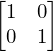

X=


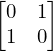

Y=


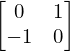

Z=


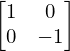

In [12]:
print ("I=")
display(sympy.Matrix(I.matrix))
print ("X=")
display(sympy.Matrix(X.matrix))
print ("Y=")
display(sympy.Matrix(Y.matrix))
print ("Z=")
display(sympy.Matrix(Z.matrix))

V=


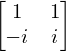

V*X=


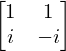

V*Y=


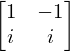

V*Z=


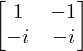

In [13]:
print ("V=")
display(sympy.Matrix(V.matrix))
A=V*X
print ("V*X=")
display(sympy.Matrix(A.matrix))
A=V*Y
print ("V*Y=")
display(sympy.Matrix(A.matrix))
A=V*Z
print ("V*Z=")
display(sympy.Matrix(A.matrix))

W=


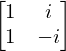

W*X=


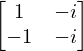

W*Y=


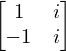

W*Z=


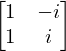

In [14]:
print ("W=")
display(sympy.Matrix(W.matrix))
A=W*X
print ("W*X=")
display(sympy.Matrix(A.matrix))
A=W*Y
print ("W*Y=")
display(sympy.Matrix(A.matrix))
A=W*Z
print ("W*Z=")
display(sympy.Matrix(A.matrix))

H=


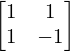

H*X=


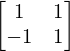

H*Y=


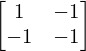

H*Z=


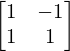

In [15]:
print ("H=")
display(sympy.Matrix(H.matrix))
A=H*X
print ("H*X=")
display(sympy.Matrix(A.matrix))
A=H*Y
print ("H*Y=")
display(sympy.Matrix(A.matrix))
A=H*Z
print ("H*Z=")
display(sympy.Matrix(A.matrix))

H*V=


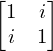

H*V*X=


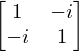

H*V*Y=


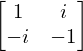

H*V*Z=


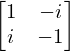

In [16]:
print ("H*V=")
A=H*V
display(sympy.Matrix(A.matrix))
A=H*V*X
print ("H*V*X=")
display(sympy.Matrix(A.matrix))
A=H*V*Y
print ("H*V*Y=")
display(sympy.Matrix(A.matrix))
A=H*V*Z
print ("H*V*Z=")
display(sympy.Matrix(A.matrix))

H*W=


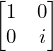

H*W*X=


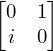

H*W*Y=


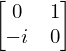

H*W*Z=


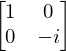

In [17]:
print ("H*W=")
A=H*W
display(sympy.Matrix(A.matrix))
A=H*W*X
print ("H*W*X=")
display(sympy.Matrix(A.matrix))
A=H*W*Y
print ("H*W*Y=")
display(sympy.Matrix(A.matrix))
A=H*W*Z
print ("H*W*Z=")
display(sympy.Matrix(A.matrix))

### An alternative approach to the elements in the Clifford group $C_1$

There are certain elements in the group $C_1$ that can be written with less gates (in particular, less Hadamard gates).

H*V = H*H*S*H*S = S*H*S =


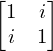

H*V*Y = H*H*S*H*S*Y = S*H*S*Y = S*H*X*S = S*Z*H*S = Sdg*H*S =


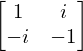

H*V*Z = H*H*S*H*S*Z = S*H*Sdg =


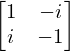

In [18]:
print ("H*V = H*H*S*H*S = S*H*S =")
A=S*H*S #H*V
display(sympy.Matrix(A.matrix))
A=Sdg*H*S #H*V*Y
print ("H*V*Y = H*H*S*H*S*Y = S*H*S*Y = S*H*X*S = S*Z*H*S = Sdg*H*S =")
display(sympy.Matrix(A.matrix))
A=S*H*Sdg #H*V*Z
print ("H*V*Z = H*H*S*H*S*Z = S*H*Sdg =")
display(sympy.Matrix(A.matrix))

H*W = H*H*S = S =


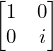

H*W*X = S*X = 


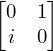

H*W*Y = S*Y =


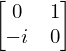

H*W*Z = Sdg =


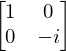

In [19]:
print ("H*W = H*H*S = S =")
A=S #H*W
display(sympy.Matrix(A.matrix))
A= S*X #H*W*X
print ("H*W*X = S*X = ")
display(sympy.Matrix(A.matrix))
A=S*Y #H*W*Y
print ("H*W*Y = S*Y =")
display(sympy.Matrix(A.matrix))
A=Sdg #H*W*Z
print ("H*W*Z = Sdg =")
display(sympy.Matrix(A.matrix))

## The Clifford group on 2 qubits

The **Pauli group** $P_2$ is generated by the tensor products of the Pauli matrices $\{A \otimes B: A,B \in \{I,X,Y,Z\}\}$. When neglecting the global phase $U(1) \cong \mathbb{C}$ we get that $P_2/U(1) \cong \mathbb{F}_2^4$. 

The **Clifford group** $C_2$ on 2-qubits is defined as the normalizer of the Pauli group $P_2$ (when neglecting the global phase $U(1) \cong \mathbb{C}$).

It turns out that $C_2/P_2 \cong Sp(4)$, where $Sp(4)$ contains all the symplectic $4 \times 4$ matrices over the field $\mathbb{F}_2$, so $Sp(4)$ has 720 elements.

According to [4], there are four distinct classes of the 2-qubit Clifford group, and it is proven that this is the optimal decomposition of the 2-qubit Clifford group in terms of the number of CNOT gates.

Recall that the CNOT gate, where qubit 0 is the control and qubit 1 is the target, is:
$CX_{0,1} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$

**Class 1:**  Consists of $576=24^2$ elements, and represents all 1-qubit Clifford operations.

Each element in this class can be written as:
$(h_0\otimes h_1) (v_0\otimes v_1) (p_0\otimes p_1)$ where $h_i \in \{I,H\}, v_i \in \{I,V,W\}$ and $p_i \in \{I,X,Y,Z\}$ ,

($h_i, v_i, p_i$ operates on the $i$-th qbit)

In [20]:
Class1Size = 2*2*3*3*4*4
print ("The size of Class 1 is: ", Class1Size)

The size of Class 1 is:  576


**Class 2 is called the CNOT-class:** Consists of $5184 = 24^2 \times 3^2$ elements, 
and contains the following sequences, which require exactly one CNOT gate.

Each element in this class can be written as:
$(h_0\otimes h_1) (v_0\otimes v_1) CX_{0,1} (v'_0\otimes v'_1) (p_0\otimes p_1)$ where $h_i \in \{I,H\}, v_i, v'_i \in \{I,V,W\}, p_i \in \{I,X,Y,Z\}$,
and $CX_{0,1}$ is a CNOT-gate, where qubit 0 is the control and qubit 1 is the target.

In [21]:
Class2Size = 2*2*3*3*3*3*4*4
print ("The size of Class 2 is: ", Class2Size)

The size of Class 2 is:  5184


**Class 3 is called the iSWAP-class:** Consists of $5184 = 24^2 \times 3^2 $ elements, 
and contains the following sequences, which require two CNOT gates.

Each element in this class can be written as:
$(h_0\otimes h_1) (v_0\otimes v_1) CX_{0,1}CX_{1,0} (v'_0\otimes v'_1) (p_0\otimes p_1)$ where $h_i \in \{I,H\}, v_i, v'_i \in \{I,V,W\}, p_i \in \{I,X,Y,Z\}$, and $CX_{0,1}, CX_{1,0}$ are CNOT-gates.

In [22]:
Class3Size = 2*2*3*3*3*3*4*4
print ("The size of Class 3 is: ", Class3Size)

The size of Class 3 is:  5184


**Class 4 is called the SWAP-class:** Consists of $576 = 24^2$ elements, 
and contains the following sequences, which require three CNOT gates.

Each element in this class can be written as:
$(h_0\otimes h_1) (v_0 \otimes v_1) CX_{0,1} CX_{1,0} CX_{0,1} (p_0\otimes p_1)$ where $h_i \in \{I,H\}, v_i, \in \{I,V,W\}, p_i \in \{I,X,Y,Z\}$, and $CX_{0,1}, CX_{1,0}$ are CNOT-gates.

In [23]:
Class4Size = 2*2*3*3*4*4
print ("The size of Class 4 is: ", Class4Size)

The size of Class 4 is:  576


**The size of the Clifford group on 2-qubits**

In [24]:
TotalSize = Class1Size + Class2Size + Class3Size + Class4Size
print ("The size of the 2-qubit Clifford group is: ", TotalSize)

The size of the 2-qubit Clifford group is:  11520
